## Kalashnik et Kalashnik 2011 - Test with SAR


Try Sam, eventually Soudelor


CAVEAT: if we want it to work, we need to take f = coriolis(abs(lat)) and above all L = R_+ (i.e the radius where the Ekman pumping zeroes)!!

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# # PyTorch
# import torch
# import torch.nn as nn
# from torch.autograd import Variable              # Convert arrays to tensors
# from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
# import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PATHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
}

In [3]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

In [4]:
### OPEN DATA
dsg = xr.open_dataset(PATHS['ds_glob_path'])

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
dsg.where(dsg.storm_name == 'SAM', drop=True).B_hol

<xarray.DataArray 'B_hol' (time: 5)>
array([1.96117778, 1.72170797, 1.54376829, 1.77344576, 2.27250997])
Coordinates:
  * time     (time) datetime64[ns] 2021-09-28T09:19:19 ... 2021-09-30T09:59:01

In [6]:
### SAM
p1 = 's1a-ew-owi-ca-20210924t210331-20210924t210556-000003-04B621_sw_al182021_cyclone.nc'
p2 = 's1b-ew-owi-ca-20210926t090903-20210926t091107-000003-0371EC_sw_al182021_cyclone.nc'
p3 = 'rs2--owi-ca-20210928t091808-20210928t092031-00003-2E28D_sw_al182021_cyclone.nc'
p4 = 's1b-ew-owi-ca-20210929t220202-20210929t220436-000003-037380_sw_al182021_cyclone.nc'
p5 = 'rs2--owi-ca-20210930t095823-20210930t095939-00003-2F7F0_sw_al182021_cyclone.nc'

Text(0.5, 1.0, 'SAM, AL182021')

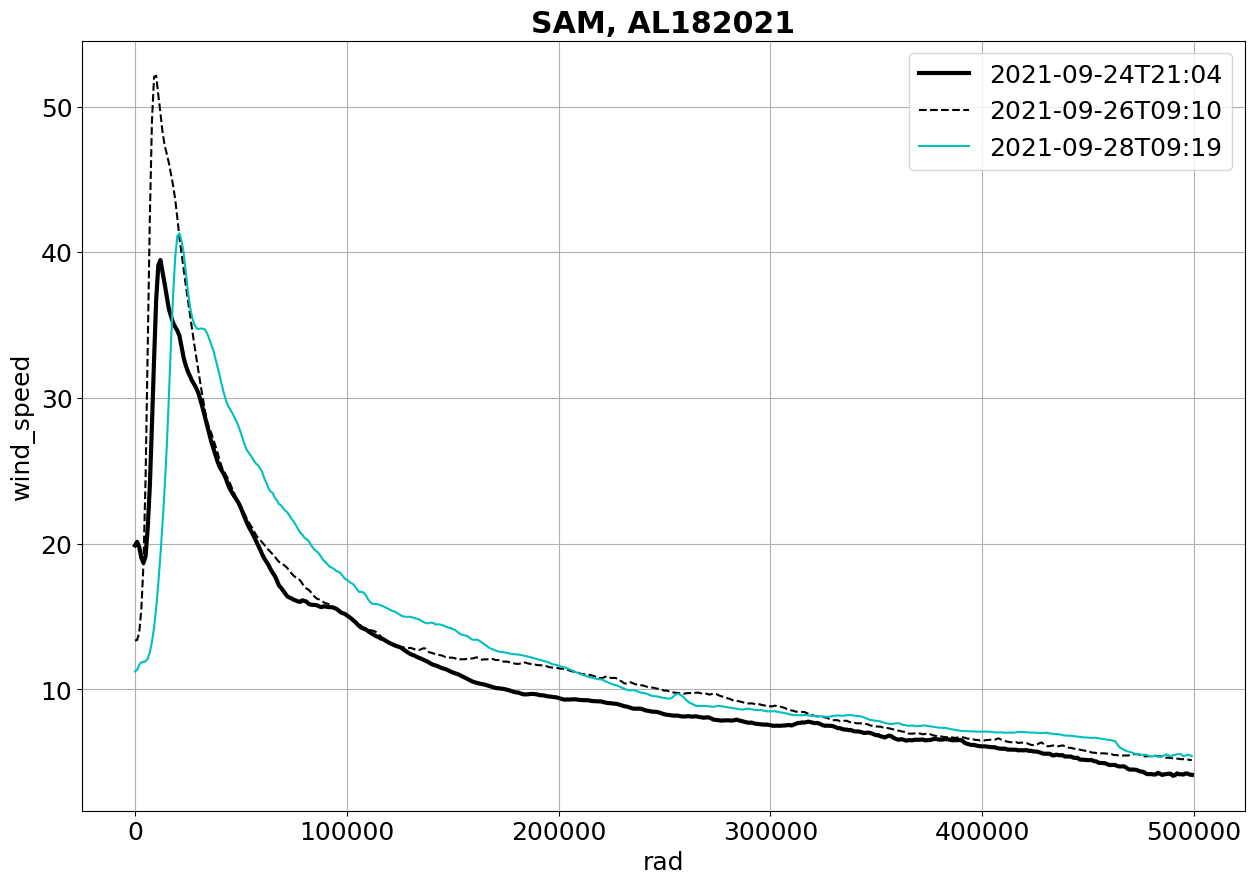

In [77]:
ds1 = xr.open_dataset(PATHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PATHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PATHS['sar_dir'] + p3).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c='k', linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c='k', linestyle='--')
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c='c')
plt.grid();plt.legend();plt.title('SAM, AL182021', weight='bold')

# 36hrs between both images

In [137]:
# To define U_star
Rmax   = float(ws1.rad[int(ws1.argmax())]) # m
Vmax   = float(ws1.max())                  # m/s

In [142]:
# Define scales
lat    = float(ds1.lat.isel(rad=0).mean(dim='theta', skipna=True))
fcor   = abs(coriolis(lat)) # maybe divide by 10 to get reasonable value of fcor * L
L      = 111000 # m

# Usefull to define characteristic values
H      = 10000  # m
U_star = 0.36    # m/s, or say it's fcor * Rmax

print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('tangential velocity --> {:.2f} m/s'.format(fcor * L))
print('vertical velocity   --> {:.2f} m/s'.format(H * U_star / L))
print('characteristic tangential velocity --> {:.1f} m/s'.format(fcor * L))
print('nb of timesteps: {:.2f}'.format(36 / (L / U_star / 3600))) 

characteristic time --> 85.6 h
tangential velocity --> 3.42 m/s
vertical velocity   --> 0.03 m/s
characteristic tangential velocity --> 3.4 m/s
nb of timesteps: 0.42


In [132]:
# Define non-dimensional (r, v)
r1 = ws1.rad / L
v1 = ws1     / (fcor * L)

V1 = xr.DataArray(
    data=v1,
    coords={'rad': r1}
)

In [133]:
def v_k10(v0, t, lbda):
    v          = np.zeros_like(v0.rad)
    # Inner-core
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})
    vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    # Near-core
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))
    v_prop_nr  = v0.interp({'rad': nr_term})
    vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
    # Outer-core
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)
    v_prop_ou  = v0.interp({'rad': ou_term})
    vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad)
    
    # Check each of the 3 pieces
    # plt.title('t={}'.format(t))
    # plt.plot(v0.rad, vin)
    # plt.plot(v0.rad, vnr)
    # plt.plot(v0.rad, vou)
    # plt.xlim(0, 3);plt.ylim(0, 3)
    # plt.grid();plt.show()
    
    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

In [134]:
# ### CHECK WITH A RANKINE PROFILE
# rss = np.linspace(0, 10, 500)
# vrk = rss * 0
# vin = 10 * rss
# vou = 10 / rss
# vrk[rss < 1]  = vin[rss < 1]
# vrk[rss >= 1] = vou[rss >= 1]

# a = xr.DataArray(
#     data=vrk,
#     coords={'rad': rss}
# )

# ts     = np.linspace(0, 2, 5)
# colors = mpl.cm.coolwarm(np.linspace(0, 1, len(ts)))

# lbda   = 0.8

# for i, t in enumerate(ts):
#     plt.plot(a.rad, v_k10(a, t=t, lbda=lbda), label='t = {}, lbda = {}'.format(t, lbda), c=colors[i])
# plt.grid();plt.legend()
# plt.xlabel('r');plt.ylabel('v')

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-pack

(0.0, 5.0)

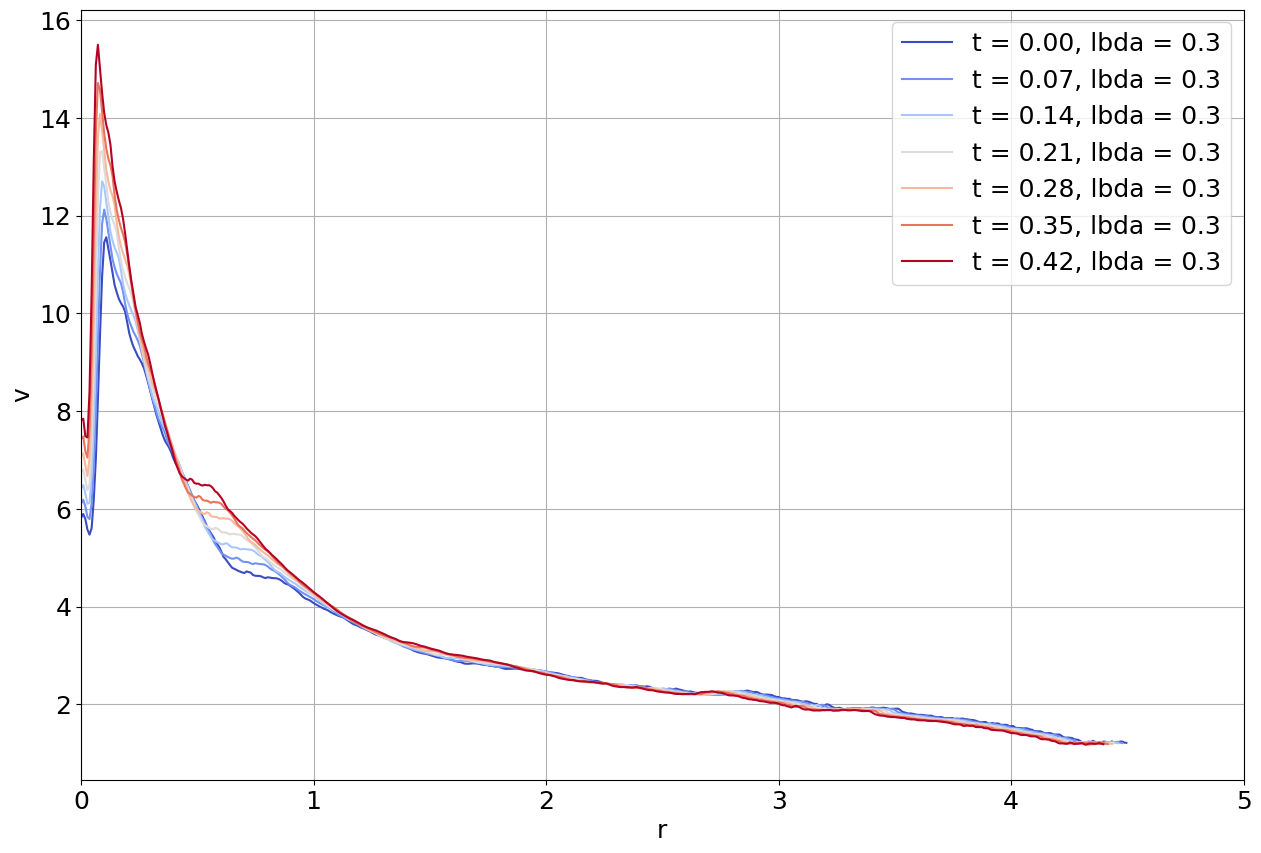

In [153]:
ts     = np.linspace(0, 0.42, 7)
colors = mpl.cm.coolwarm(np.linspace(0, 1, len(ts)))

lbda   = 0.3

for i, t in enumerate(ts):
    plt.plot(V1.rad, v_k10(V1, t=t, lbda=lbda), label='t = {:.2f}, lbda = {:.1f}'.format(t, lbda), c=colors[i])
plt.grid();plt.legend()
plt.xlabel('r');plt.ylabel('v')
plt.xlim(0, 5)

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


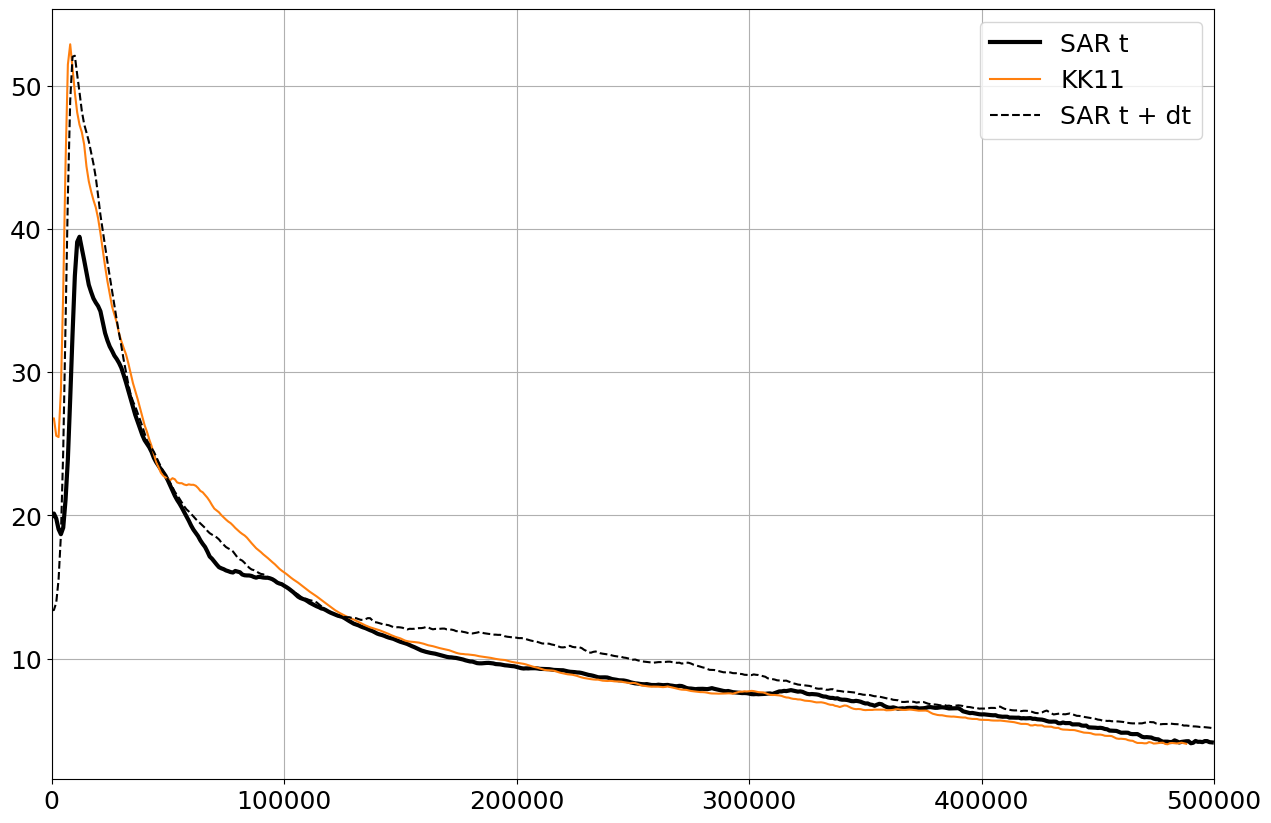

In [152]:
v_new = v_k10(V1, t=0.42, lbda=0.3)
plt.plot(ws1.rad, ws1, label='SAR t', c='k', linewidth=3)
plt.plot(V1.rad * L, v_new * fcor * L, label='KK11', c='tab:orange')
plt.plot(ws2.rad, ws2, label='SAR t + dt', c='k', linestyle='--')
plt.grid();plt.xlim(0, 500000)
plt.legend()

In [162]:
### DECREASING PHASE
# To define U_star
Rmax2  = float(ws2.rad[int(ws2.argmax())]) # m
Vmax2  = float(ws2.max())                  # m/s

lat2    = float(ds2.lat.isel(rad=0).mean(dim='theta', skipna=True))
fcor2   = abs(coriolis(lat)) # maybe divide by 10 to get reasonable value of fcor * L
L2      = 84000 # m

U_star2 = fcor2 * Rmax2

r2 = ws2.rad / L2
v2 = ws2     / (fcor2 * L2)

V2 = xr.DataArray(
    data=v2,
    coords={'rad': r2}
)

print('characteristic time --> {:.1f} h'.format(L2 / U_star2 / 3600))
print('tangential velocity --> {:.2f} m/s'.format(fcor2 * L2))
print('nb of timesteps: {:.2f}'.format(48 / (L / U_star / 3600))) 

characteristic time --> 75.8 h
tangential velocity --> 2.58 m/s
nb of timesteps: 0.56


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-pack

(0.0, 5.0)

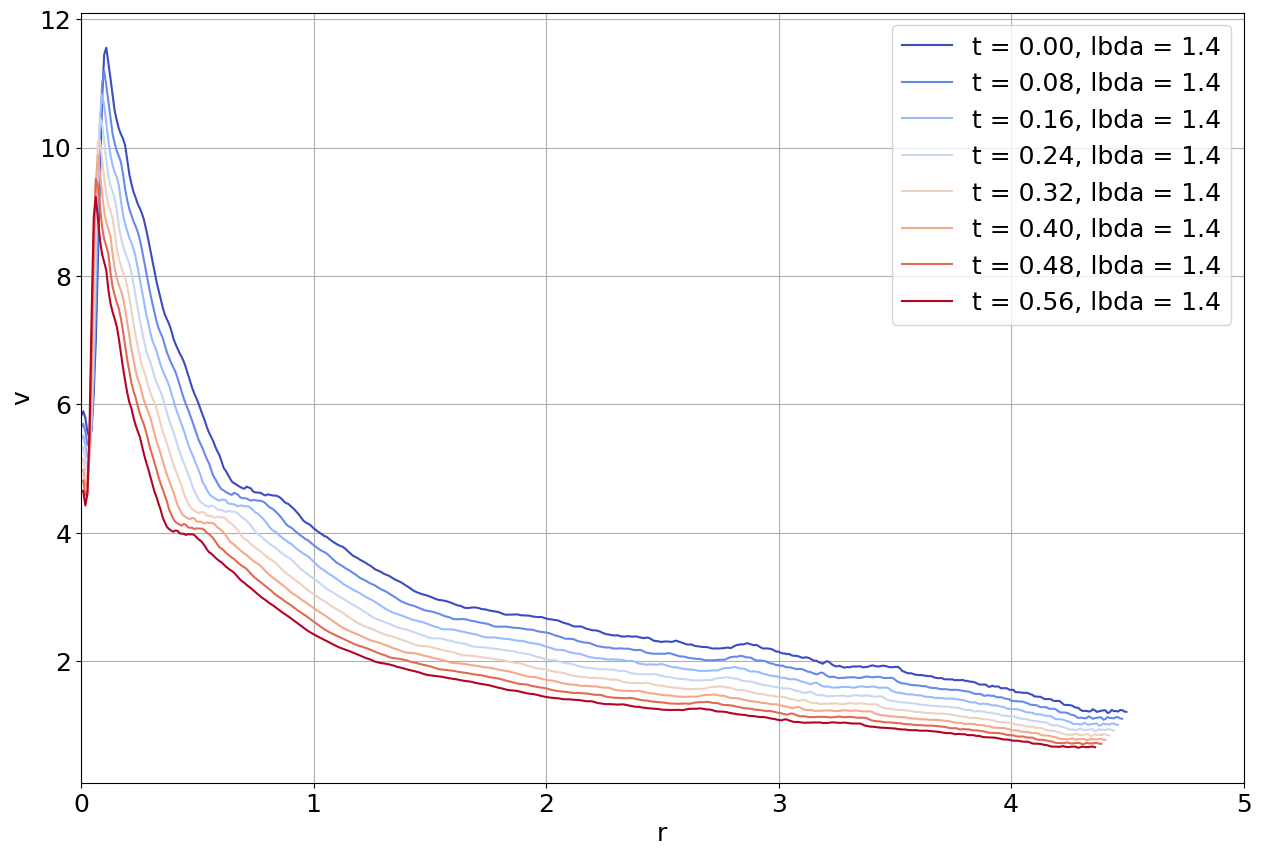

In [167]:
ts     = np.linspace(0, 0.56, 8)
colors = mpl.cm.coolwarm(np.linspace(0, 1, len(ts)))

lbda   = 1.4

for i, t in enumerate(ts):
    plt.plot(V1.rad, v_k10(V1, t=t, lbda=lbda), label='t = {:.2f}, lbda = {:.1f}'.format(t, lbda), c=colors[i])
plt.grid();plt.legend()
plt.xlabel('r');plt.ylabel('v')
plt.xlim(0, 5)

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


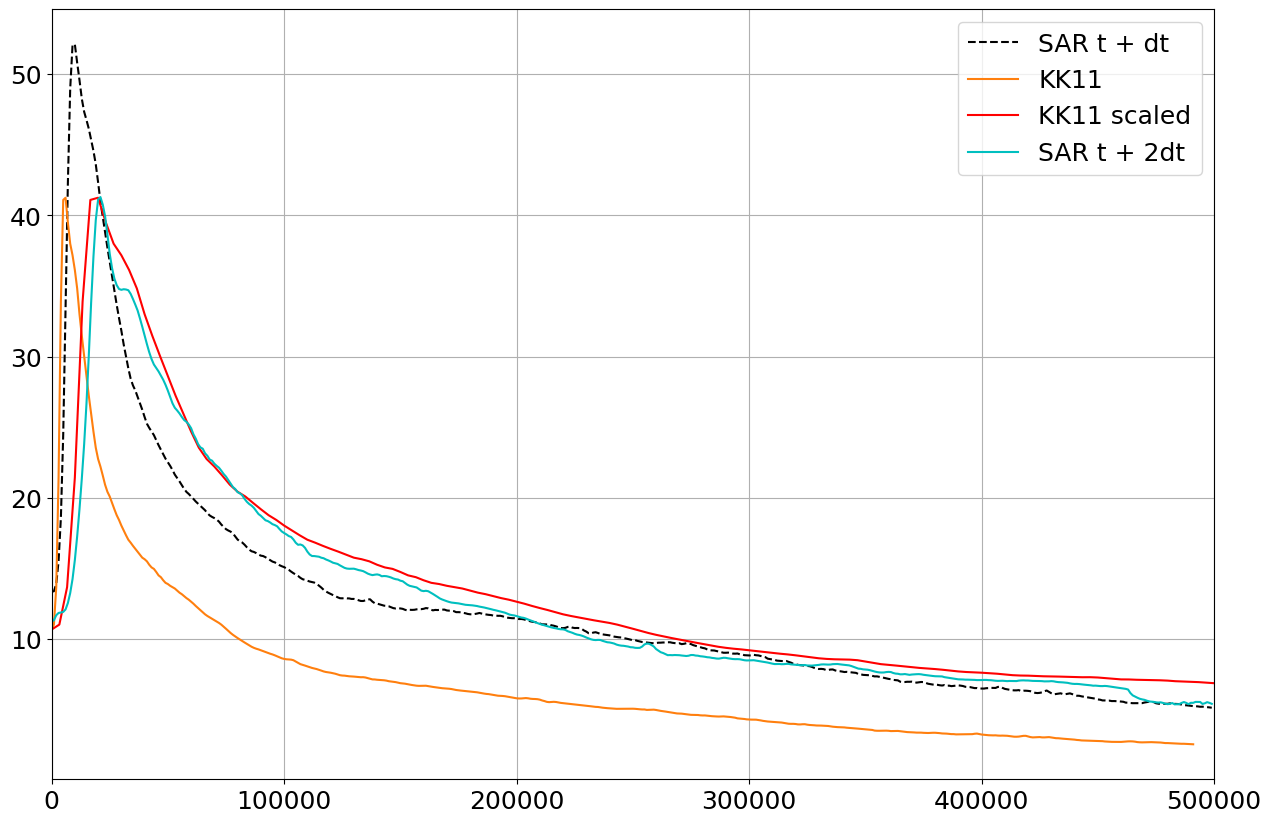

In [166]:
v_new2 = v_k10(V2, t=0.56, lbda=1.4)
plt.plot(ws2.rad, ws2, label='SAR t + dt', c='k', linestyle='--')
plt.plot(V2.rad * L2, v_new2 * fcor2 * L2, label='KK11', c='tab:orange')
plt.plot(V2.rad * 280000, v_new2 * fcor2 * L2, label='KK11 scaled', c='r')
plt.plot(ws3.rad, ws3, label='SAR t + 2dt', c='c', )
plt.grid();plt.xlim(0, 500000)
plt.legend()